In [6]:
import itertools
from math import sqrt
import multiprocessing as mp
from multiprocessing import Pool
#mp.set_start_method('spawn')

import matplotlib
from matplotlib import pyplot as plt

import numpy as np

font = {'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"]=8,8
matplotlib.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True
plt.style.use('seaborn-whitegrid')

Defines and evaluates denominators in the RG equations. The denominators in the RG equations are
$$
d_0 = \omega - \frac{1}{2}\left(D - \mu\right) - \frac{U}{2} + \frac{K}{2}
$$
$$
d_1 = \omega - \frac{1}{2}\left(D - \mu\right) + \frac{U}{2} + \frac{J}{2}
$$
$$
d_2 = \omega - \frac{1}{2}\left(D - \mu\right) + \frac{J}{4} + \frac{K}{4}
$$

In [7]:
def den(w, D, U, J, K, Df):
    d0 = w - 0.5 * (D - Df) - U/2 + K/2
    d1 = w - 0.5 * (D - Df) + U/2 + J/2
    d2 = w - 0.5 * (D - Df) + J/4 + K/4
    return d0, d1, d2

# RG Equations

The RG equations for the symmetric spin-charge Anderson-Kondo are 

$$
\Delta U = 4|V|^2 \left[\frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{U}{2} + \frac{1}{2}J}  - \frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) - \frac{U}{2} + \frac{1}{2}K}\right] + \sum_{k<\Lambda_j} \frac{3}{4}\frac{K^2 - J^2}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K}
$$

$$
\Delta V = \frac{V K}{16}\left(\frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) - \frac{U}{2} + \frac{1}{2}K} + \frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K} \right) - \frac{3VJ}{4}\left( \frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{U}{2} + \frac{1}{2}J} + \frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K} \right)
$$

$$
\Delta J = - J^2\left(\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K\right)^{-1}
$$

$$
\Delta K = - K^2\left(\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K\right)^{-1}
$$

The following equation accepts the coupling values at the $j^{th}$ step of the RG, applies the RG equations on them and returns the couplings for the $(j-1)^{th}$ step. _If any coupling changes sign, it is set to 0._

In [8]:

def rg(w, D, U, V, J, K, N, Df):
    dens = den(w, D, U, J, K, Df)
    deltaU = -4 * V**2 * (1/dens[0] - 1/dens[1]) - (3* (J**2 - K**2)/8) * D / dens[2]
    deltaV = (1/16) * K * V * (1/dens[0] - 1/dens[2]) - (3/4) * J * V * (1/dens[1] + 1/dens[2])
    deltaJ = - J**2 / dens[2]
    deltaK = - K**2 / dens[2]

    n = 2*np.pi*N*sqrt(D/Df)
    U = 0 if (U + n*deltaU) * U <= 0 else U + n*deltaU
    V = 0 if (V + n*deltaV) * V <= 0 else V + n*deltaV
    J = 0 if (J + n*deltaJ) * J <= 0 else J + n*deltaJ
    K = 0 if (K + n*deltaK) * K <= 0 else K + n*deltaK

    return U, V, J, K

The following function does one complete RG for a given set of bare couplings and returns arrays of the flowing couplings.

In [9]:
def complete_RG(w, D0, U0, V0, J0, K0, N=10):
    U = U0
    V = V0
    J = J0
    K = K0
    N = 100
    Df = D0/2
    old_den = den(w, D0, U, J, K, Df)[2]
    x, y1, y2, y3, y4 = [], [], [], [], []
    flag = False
    for D in np.linspace(D0, Df, N):
        x.append(D)
        y1.append(U)
        y2.append(J)
        y3.append(K)
        y4.append(V)
        new_den = den(w, D, U, J, K, Df)[2]
        if old_den * new_den <= 0:
            flag = True
            return [x, y1, y2, y3, y4, flag]
        old_den = new_den
        U, V, J, K = rg(w, D, U, V, J, K, N, Df)
    return [x, y1, y2, y3, y4, flag]

# 1. $V=0$

First we will look at the simplified case of $V=0$. Since the RG equation for $V$ involves $V$, it will not flow. We need to look only at $U$, $J$ and $K$. Depending on the value of $\omega$, the denominator can be either positive or negative. We look at the two cases separately.

## a. $\omega - \frac{\epsilon_q}{2} + \frac{1}{4}J + \frac{1}{4}K>0$ (high $\omega$):

These aren't truly URG fixed points because the denominator will not converge towards zero.

### i. $J=K$

Since $\Delta U \propto K^2 - J^2$, $U$ will be marginal here.

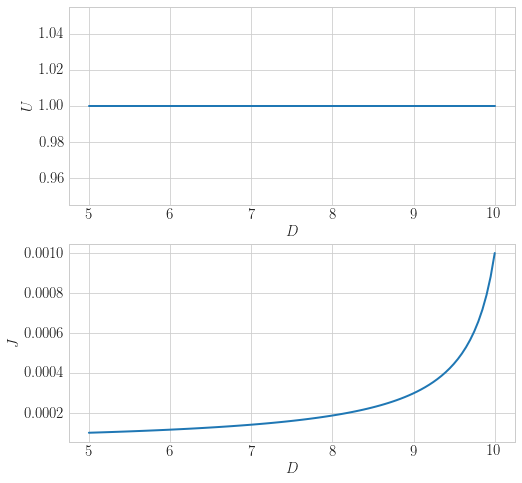

In [10]:
w = 10
D0 = 10
U0 = 1
J0 = K0 = 0.001
V0 = 0
Df = D0/2
x, y1, y2 = complete_RG(w, D0, U0, V0, J0, K0)[0:3]
fig, ax = plt.subplots(nrows=2)
ax[0].set_ylabel(r'$U$')
ax[1].set_ylabel(r'$J$')
ax[0].set_xlabel(r'$D$')
ax[1].set_xlabel(r'$D$')
ax[0].plot(x, y1)
ax[1].plot(x, y2)
plt.show()

### ii. $J > K$

Since $\Delta U \propto K^2 - J^2$, $U$ will be irrelevant here.

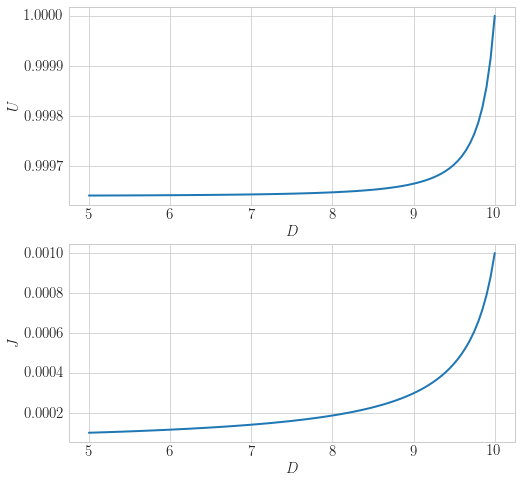

In [11]:
w = 10
D0 = 10
U0 = 1
J0 = 0.001
K0 = 0.0009
V0 = 0
x, y1, y2 = complete_RG(w, D0, U0, V0, J0, K0)[0:3]
fig, ax = plt.subplots(nrows=2)
ax[0].set_ylabel(r'$U$')
ax[1].set_ylabel(r'$J$')
ax[0].set_xlabel(r'$D$')
ax[1].set_xlabel(r'$D$')
ax[0].plot(x, y1)
ax[1].plot(x, y2)
plt.show()

### iii. $J < K$

Since $\Delta U \propto K^2 - J^2$, $U$ will be relevant here.

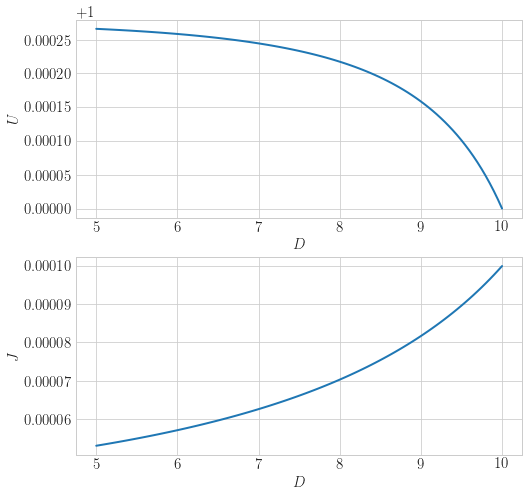

In [12]:
w = 10
D0 = 10
U0 = 1
J0 = 0.0001
K0 = 0.0002
V0 = 0
x, y1, y2 = complete_RG(w, D0, U0, V0, J0, K0)[0:3]
fig, ax = plt.subplots(nrows=2)
ax[0].set_ylabel(r'$U$')
ax[1].set_ylabel(r'$J$')
ax[0].set_xlabel(r'$D$')
ax[1].set_xlabel(r'$D$')
ax[0].plot(x, y1)
ax[1].plot(x, y2)
plt.show()

## b. $\omega - \frac{\epsilon_q}{2} + \frac{1}{4}J + \frac{1}{4}K<0$ (low $\omega$):

This is the regime where we achieve true strong-coupling fixed points in $J,K$. The signature of $K^2 - J^2$ will determine whether $U$ is relevant or irrelevant.

### i. $J>K$

In [13]:
w = 15
D0 = 15
U0 = 1
J0 = 0.0002
K0 = 0.0001
V0 = 0
x, y1, y2, y3, y4, flag = complete_RG(w, D0, U0, V0, J0, K0)
if flag == True:
    fig, ax = plt.subplots(nrows=2)
    ax[0].set_ylabel(r'$U$')
    ax[1].set_ylabel(r'$J$')
    ax[0].set_xlabel(r'$D$')
    ax[1].set_xlabel(r'$D$')
    ax[0].plot(x, y1)
    ax[1].plot(x, y2)
    plt.show()
else:
    print ("Not fixed point.")

Not fixed point.


### i. $J<K$

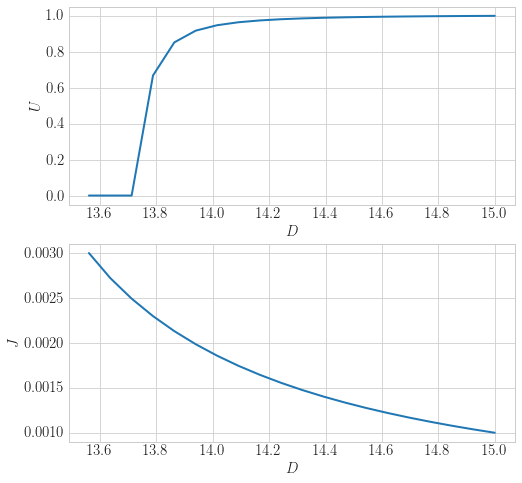

In [14]:
w = -20
D0 = 15
U0 = 1
J0 = 0.001
K0 = 0.002
V0 = 0
x, y1, y2, y3, y4, flag = complete_RG(w, D0, U0, V0, J0, K0)
if flag == True:
    fig, ax = plt.subplots(nrows=2)
    ax[0].set_ylabel(r'$U$')
    ax[1].set_ylabel(r'$J$')
    ax[0].set_xlabel(r'$D$')
    ax[1].set_xlabel(r'$D$')
    ax[0].plot(x, y1)
    ax[1].plot(x, y2)
    plt.show()
else:
    print ("Not fixed point.")

To wrap up the $V=0$ case, we look at an RG-invariant:

$\frac{\Delta J}{\Delta K} = \frac{J^2}{K^2} \implies \frac{1}{J} - \frac{1}{K} = \frac{1}{J_0} - \frac{1}{K_0}$

Note that this is an invariant even when $V$ is turned on.

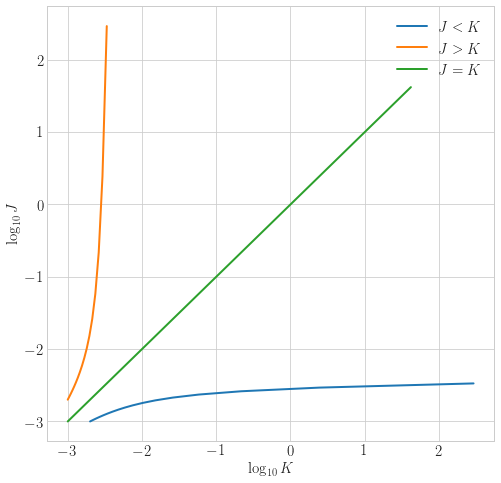

In [15]:
w = -15
D0 = 15
U0 = 1
J0 = 0.001
K0 = 0.002
V0 = 0
x, y1, y2, y3, y4, flag = complete_RG(w, D0, U0, V0, J0, K0)
if flag == False:
    print ("It is not a fixed point.")
    exit
plt.xlabel(r"$\log_{10}K$")
plt.ylabel(r"$\log_{10}J$")
plt.plot(np.log10(y3), np.log10(y2), label=r'$J<K$')
J0 = 0.002
K0 = 0.001
x, y1, y2, y3, y4, flag = complete_RG(w, D0, U0, V0, J0, K0)
if flag == False:
    print ("It is not a fixed point.")
    exit
plt.plot(np.log10(y3), np.log10(y2), label=r'$J>K$')
J0 = 0.001
K0 = 0.001
x, y1, y2, y3, y4, flag = complete_RG(w, D0, U0, V0, J0, K0)
if flag == False:
    print ("It is not a fixed point.")
    exit
plt.plot(np.log10(y3), np.log10(y2), label=r'$J=K$')
plt.legend()
plt.show()

## Phase Diagram

<img src="../figures/phases.svg" align="left" width=50%>


# 2. $V > 0$

The inclusion of $V$ will mean that there will not by any sharply defined phase of $U^*$ any more. We will still be working in the regime where $J,K$ flow to strong-coupling, and since those RG equations do not depend on $V$, their flows are unchanged. The behaviour of $U$ will get complicated however. To make 
sense, we will see how the total (over a range of $\omega$ and bare $U$) number of fixed points where $U^* > U_0$ and the total number of fixed points where $U^* < U_0$, in each of the four quadrants of the phase diagram, varies against the bare value $V_0$.

## a. Behaviour of distribution of fixed points as a function of bare $V$

We can classify the fixed points into three classes: $U*=0$, $U^* > U_0$ and $U^* < U_0$. The number of fixed points in each class for $V=0$ has already been clarified in the $V=0$ section, specially in the phase diagram. For that, we will first create some helper functions.
- count_fp(args): returns the fraction of fixed points with $U^*=0$ ($c_0$), $U^* > U_0$ ($c_1$) and $U^* < U_0$ ($c_2$), for given values of $D_0, V_0, J_0, K_0$
- get_Vc(args): returns the critical $V_0$ at which $c_0=c_1+c_2$
- plot_count(args): just plots the fraction of fixed points in each class as a function of bare values, given the data
- plot_frac(args): just plots the fraction of $U^*=0$ or $U^* \neq 0$ fixed points a particular $V_0$, as a function of $D$

In [16]:
def count_fp(D0, V0, J0, K0, sign=1, delta=0.1):
    w_range = np.arange(-2*D0, 2*D0, delta*10)
    U_range = np.arange(sign*delta, sign*(10 + delta), sign*delta)
    data = itertools.product(w_range, [D0], U_range, [V0], [J0], [K0])
    count = np.zeros(3)
    for outp in Pool(processes=30).starmap(complete_RG, data):
        U0 = outp[1][0]
        U_fp = outp[1][-1]
        if U_fp ==0:
            count[0] += 1
        elif U_fp > U0 and outp[-1] == True:
            count[1] += 1
        elif U_fp < U0 and outp[-1] == True:
            count[2] += 1
    return count

In [17]:
def get_Vc(V0_range, c0, c1):
    diff = (c1-c0)[0]
    for i in range(1,len(c1-c0)):
        if diff * (c1-c0)[i] <=0 :
            return V0_range[i]
    return -1

In [18]:
def plot_count(V0_range, count, title):
    plt.plot(V0_range, count[0], marker=".", color='r', label=r"$U^*=0$" )
    plt.plot(V0_range, count[1], marker=".", color='b', label=r"$U^* > U_0$")
    plt.plot(V0_range, count[2], marker=".", color='g', label=r"$U^* < U_0$")
    plt.legend()
    plt.title(title)
    plt.xlabel(r"$V_0$")
    plt.ylabel(r"log of (number of fixed points+1)")
    plt.show()

In [19]:
def plot_frac(D0_range, V0, frac, title):
    plt.plot(D0_range, frac[0])
    plt.xlabel(r"$D_0$")
    plt.ylabel(r"ratio of $U^*=0$ and $U^*\neq 0$")
    plt.title(title+" $V_0 = {}$".format(V0[0]))
    plt.show()
    plt.plot(D0_range, frac[1])
    plt.xlabel(r"$D_0$")
    plt.ylabel(r"ratio of $U^*=0$ and $U^*\neq 0$")
    plt.title(title+" $V_0 = {}$".format(V0[1]))
    plt.show()

We will first check how the $c_i$ vary as functions of $V$, in each quadrant. This will be a rough investigation to see the general behaviour in each of the quadrants.

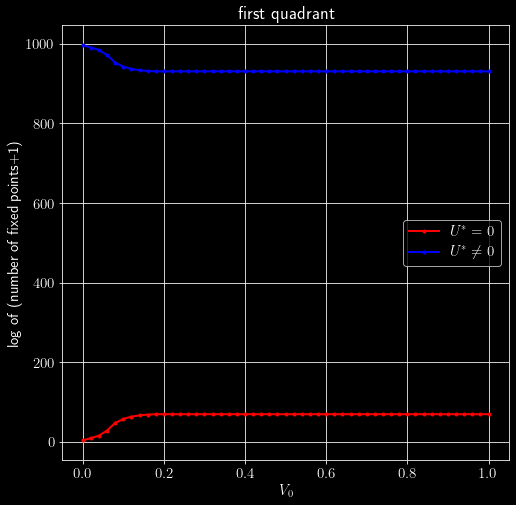

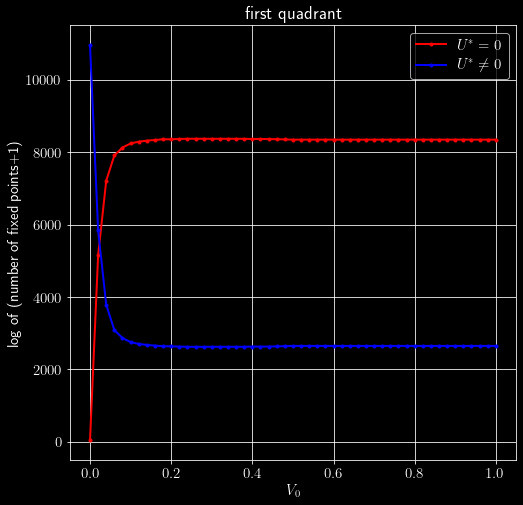

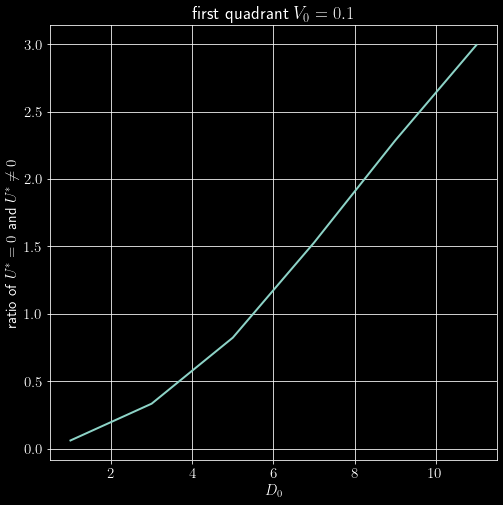

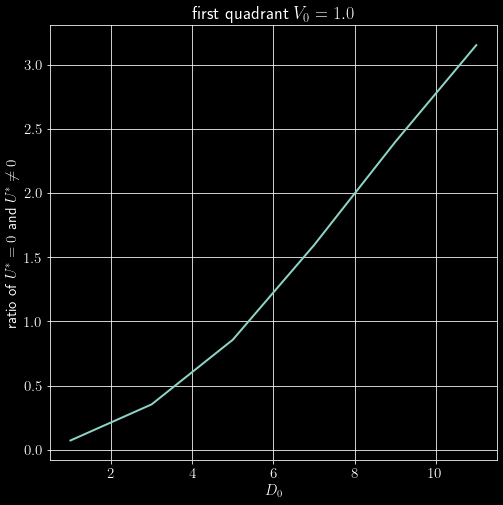

[7, 9, 11]
[0.04, 0.04, 0.04]


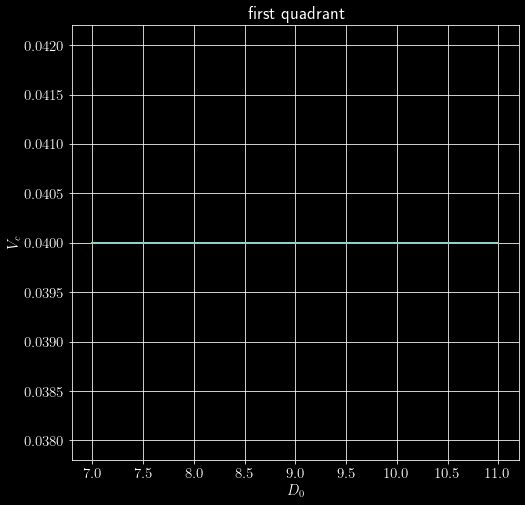

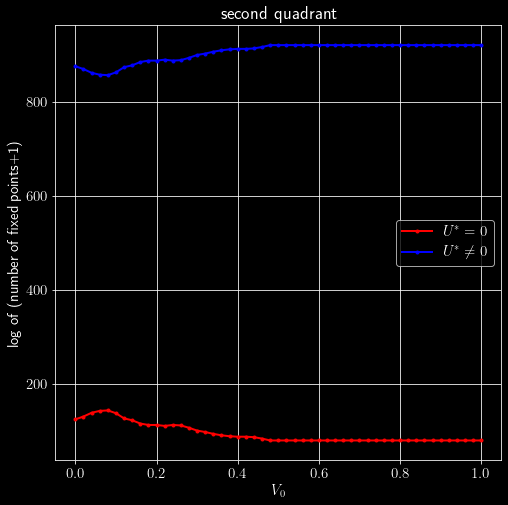

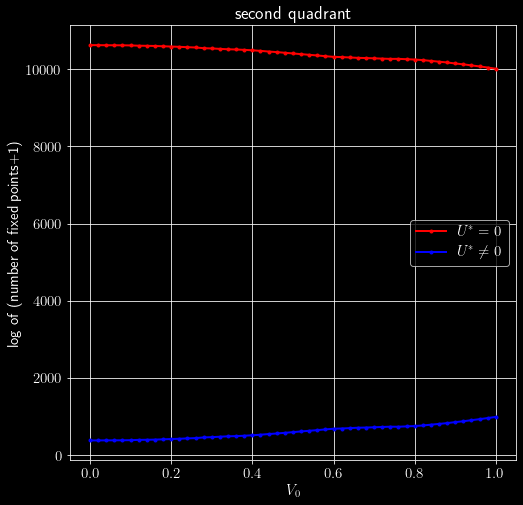

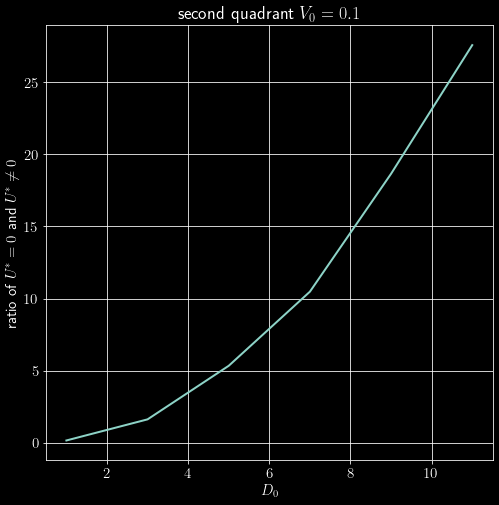

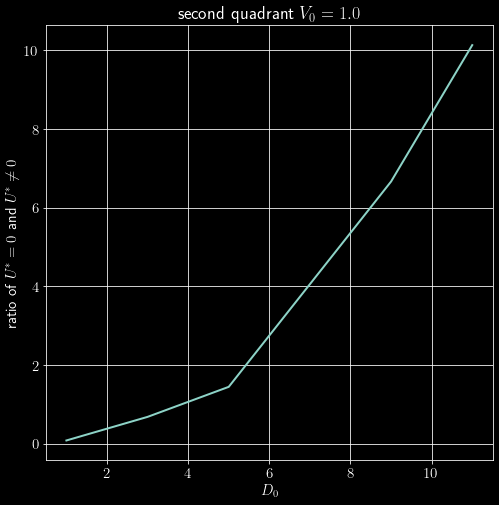

[3]
[0.46]


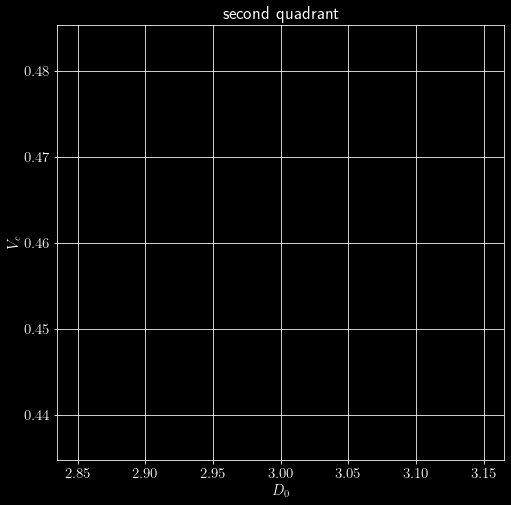

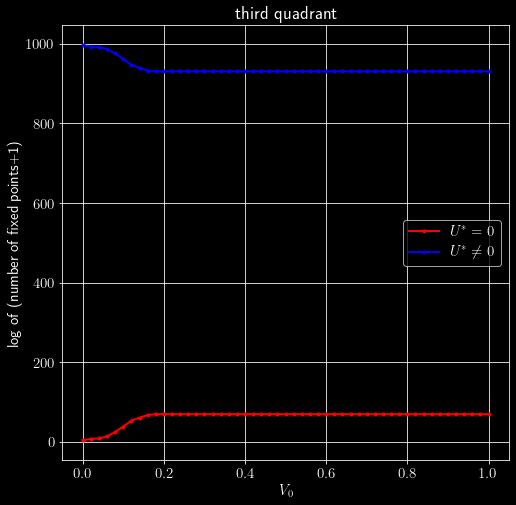

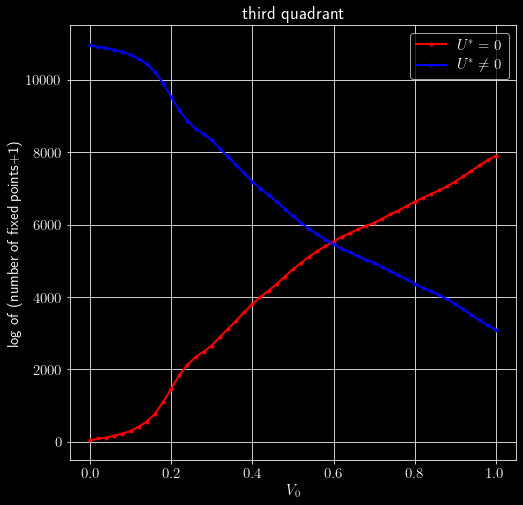

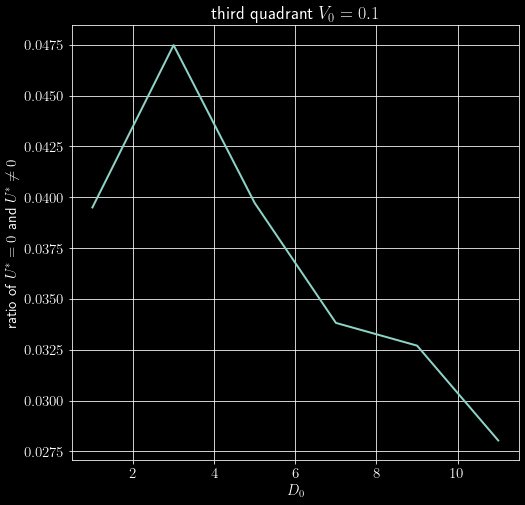

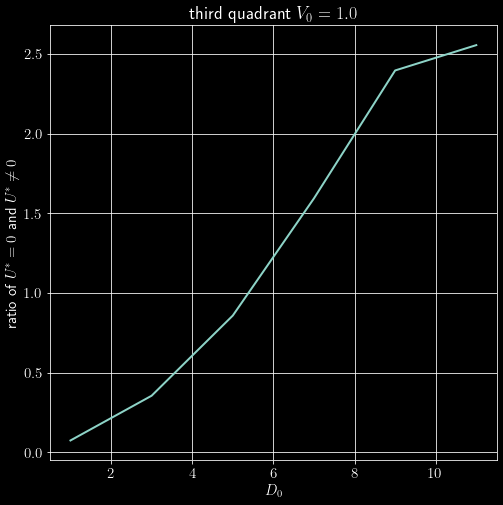

[7, 9, 11]
[0.54, 0.6, 0.6]


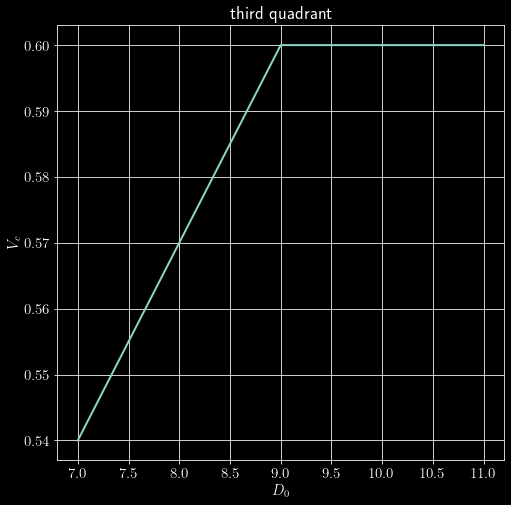

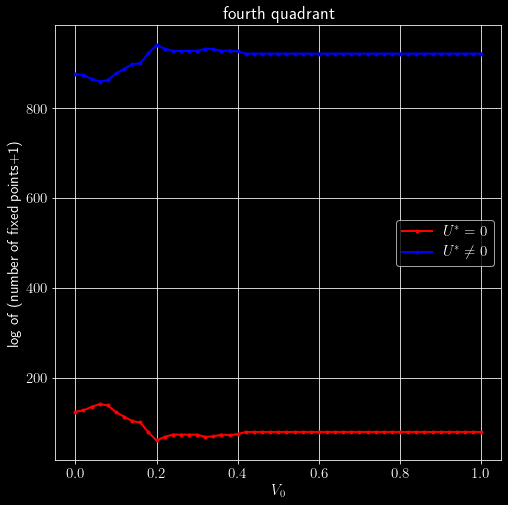

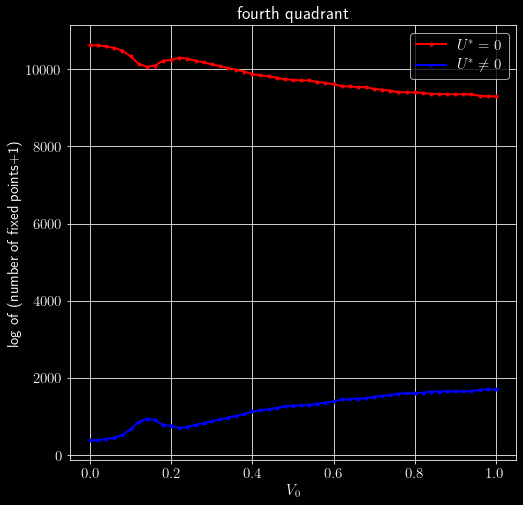

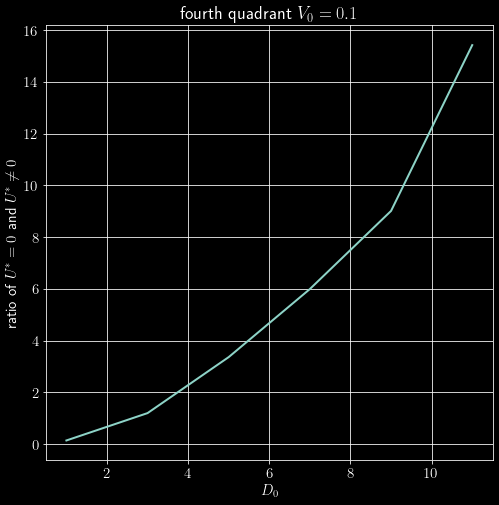

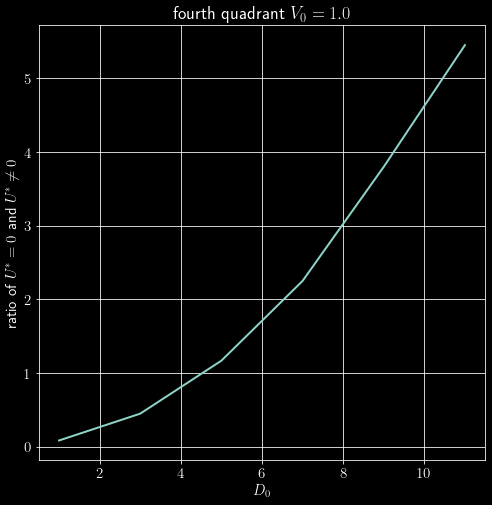

[3]
[0.16]


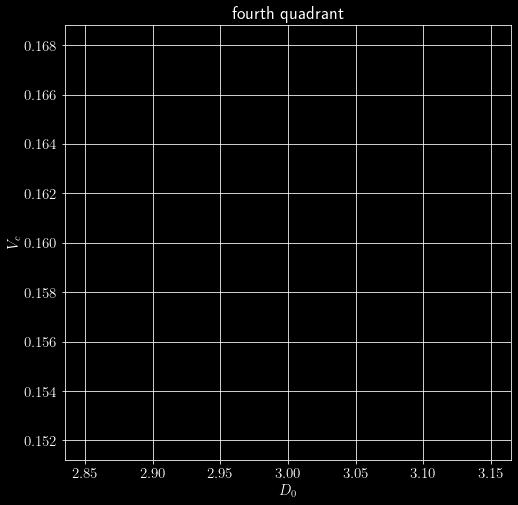

In [28]:
def plot_all(J0, K0, sign, title):
    D0_range = range(1, 12, 2)
    V_crit, D_crit = [], []
    frac1, frac2 = [], []
    V0_range = np.arange(0,1.01,0.02)
    index1 = np.where(V0_range <= 0.1)[0][-1]
    index2 = np.where(V0_range >= 1)[0][0]
    for D0 in D0_range:
        c0, c1, c2 = [], [], []
        for V0 in V0_range:
            count = count_fp(D0, V0, J0, K0, sign, delta=0.1)
            c0.append(count[0]/sum(count))
            c1.append(count[1]/sum(count))
            c2.append(count[2]/sum(count))
        if D0 == D0_range[0] or D0 == D0_range[-1]:
            plot_count(V0_range, [c0, c1, c2], title)
        c0, c1, c2 = np.array(c0), np.array(c1), np.array(c2)
        Vc = get_Vc(V0_range, c0, c1+c2)
        if Vc != -1:
            V_crit.append(Vc)
            D_crit.append(D0)
    
    plot_frac(D0_range, V0_range, [c0, c1, c2], title, indices)
    
    print (D_crit)
    print (V_crit)
    plt.plot(D_crit, V_crit)
    plt.title(title)
    plt.xlabel(r"$D_0$")
    plt.ylabel(r"$V_c$")
    plt.show()
    

plot_all(0.4, 0.3, 1, r"first quadrant")
plot_all(0.3, 0.4, 1, r"second quadrant")
plot_all(0.3, 0.4, -1, r"third quadrant")
plot_all(0.4, 0.3, -1, r"fourth quadrant")

We can infer the following points:
- In the first and third quadrant, there is a transition from $U^*\neq 0$ to $U*=0$ as the bandwidth increases. There is a subtle difference in the two quadrants however. It seems like the transition point is shifting to lower values in the first quadrant while it is increasing in the third quadrant. This suggests that with increasing bandwidth, the transition becomes more favourable in the first quadrant and more difficult in the third. The next step is therefore to check in greater detail the behaviour of the critical $V$ as a function of $D$.
- In the second and fourth quadrant, we cannot see any transition, but it appears that a lower choice of the bandwidth would have shown a transition. This in turn suggests that with increase in bandwidth there will be no transition. 

This is a more detailed investigation of the nature of the fixed points in each of the quadrants, under varying $D$.

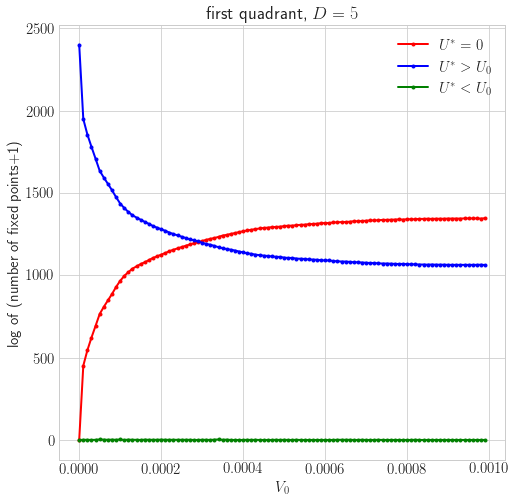

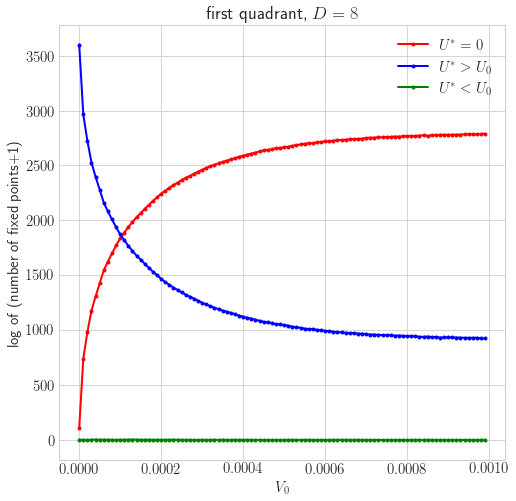

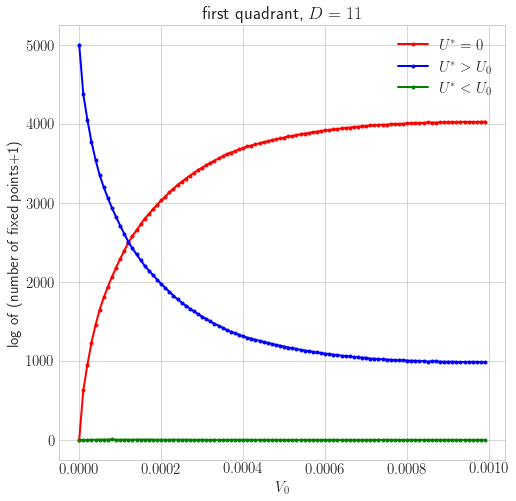

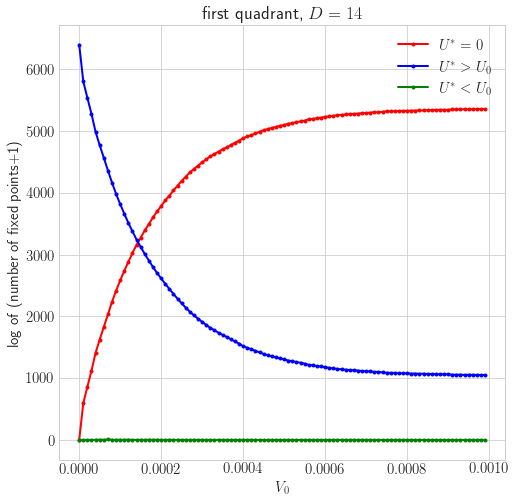

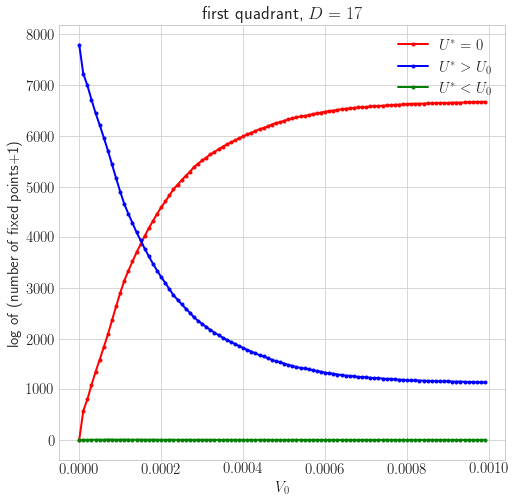

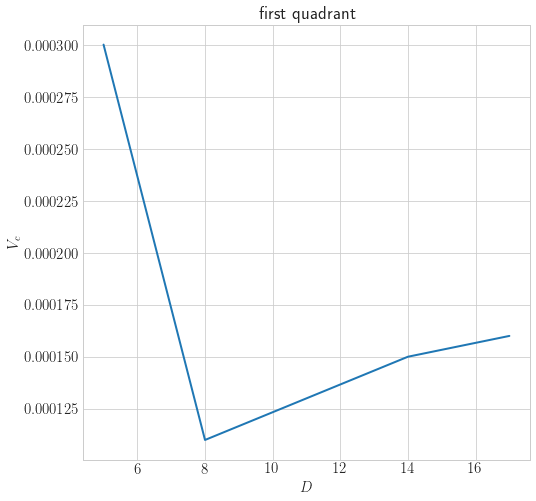

In [22]:
def plot_all(J0, K0, sign, title):
    D0_range = range(5, 20, 3)
    V_crit, D_crit = [], []
    frac1, frac2 = [], []
    V0_range = np.arange(0,0.001,0.00001)
    for D0 in D0_range:
        c0, c1, c2 = [], [], []
        for V0 in V0_range:
            count = count_fp(D0, V0, J0, K0, sign, delta=0.1)
            c0.append(count[0])
            c1.append(count[1])
            c2.append(count[2])
        plot_count(V0_range, [c0, c1, c2], title+r", $D={}$".format(D0))
        c0, c1, c2 = np.array(c0), np.array(c1), np.array(c2)
        V_crit.append(get_Vc(V0_range, c0, c1+c2))
    plt.plot(D0_range, V_crit)
    plt.title(title)
    plt.xlabel(r"$D$")
    plt.ylabel(r"$V_c$")
    plt.show()

plot_all(0.002, 0.001, 1, r"first quadrant")
#plot_all(0.001, 0.002, 1, r"second quadrant")
#plot_all(0.001, 0.002, -1, r"third quadrant")
#plot_all(0.002, 0.001, -1, r"fourth quadrant")

## Behaviour of $V$

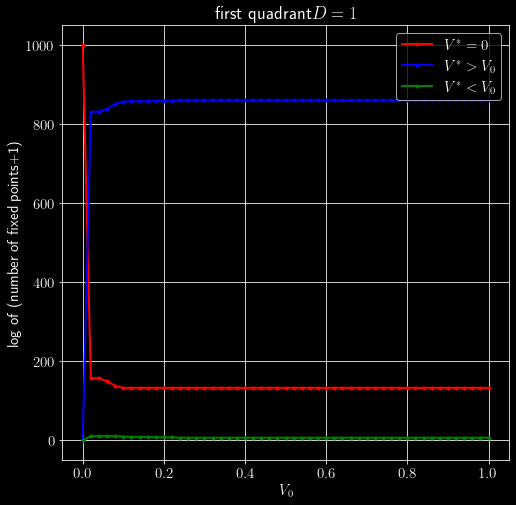

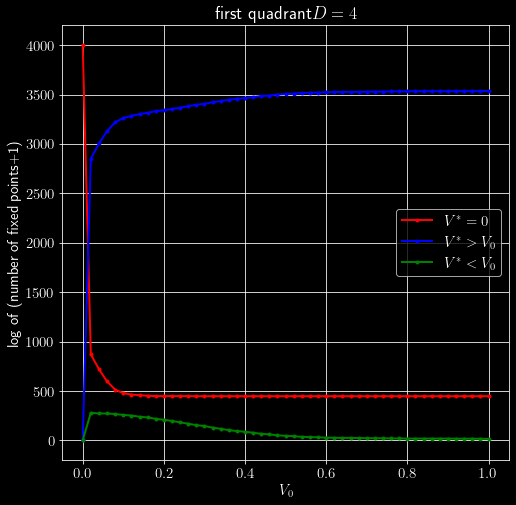

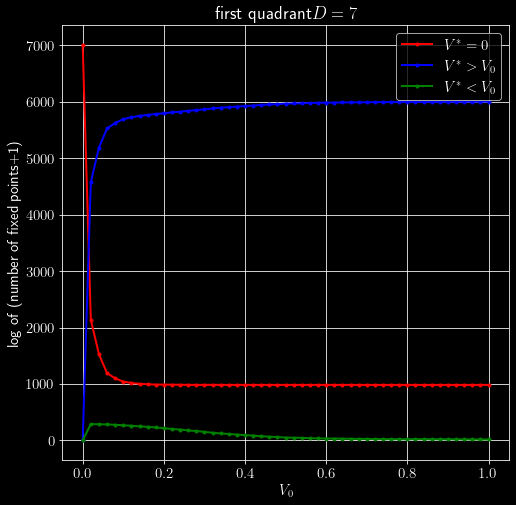

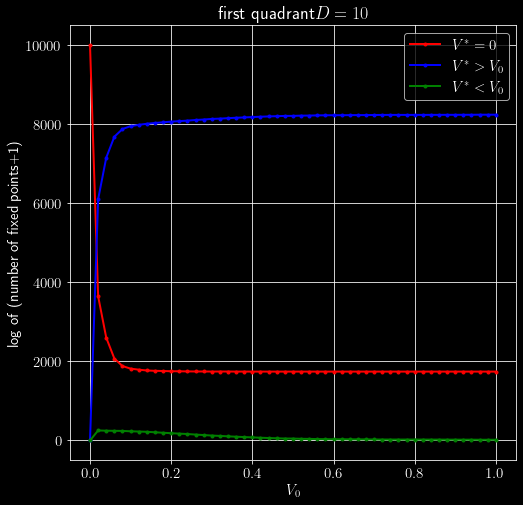

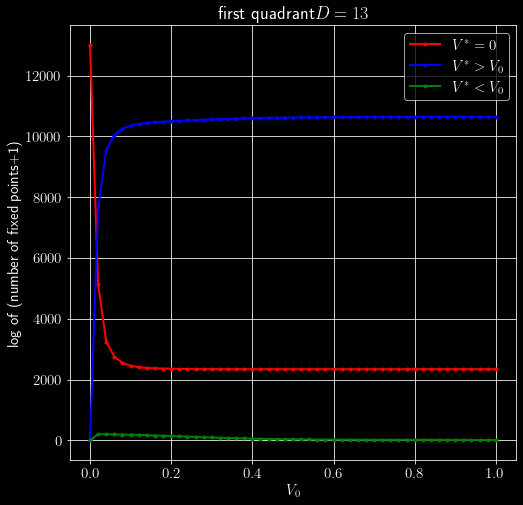

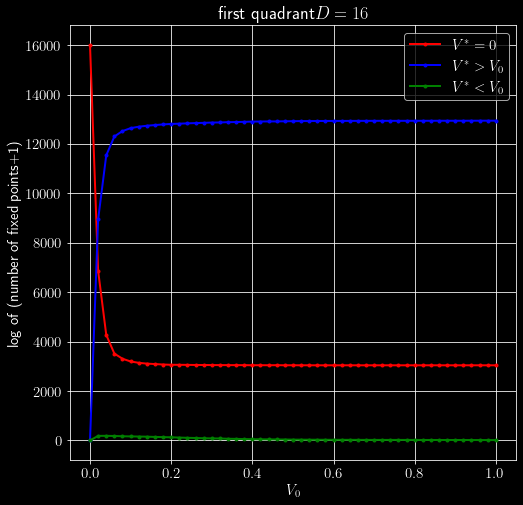

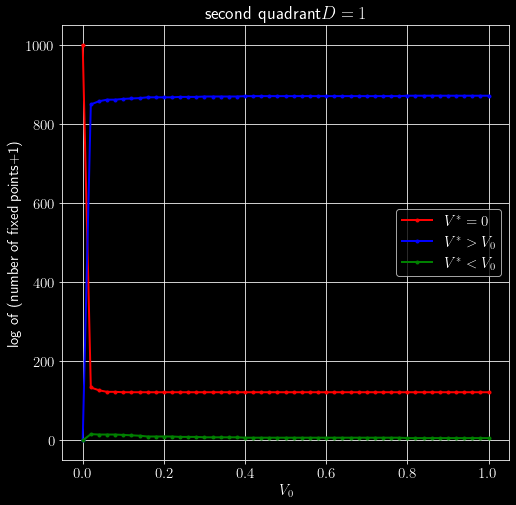

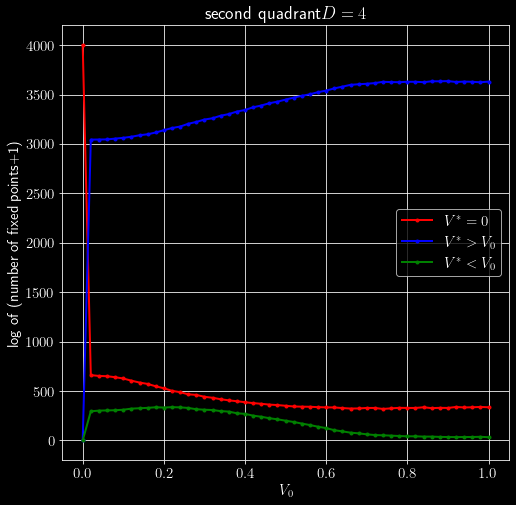

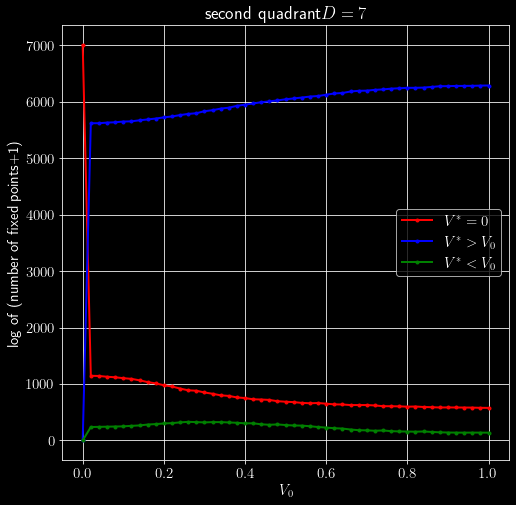

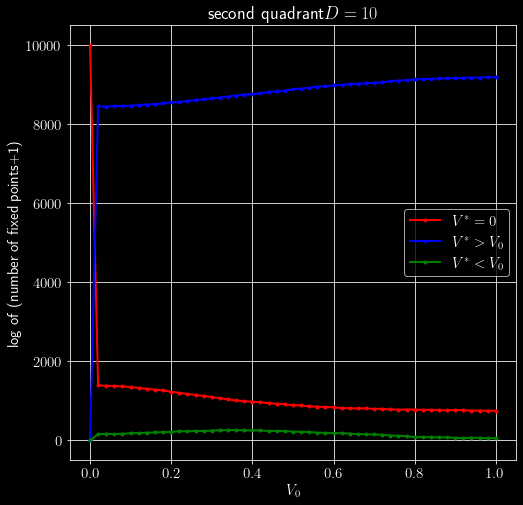

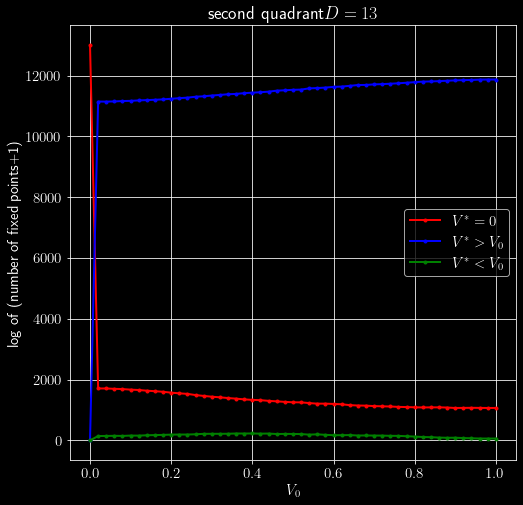

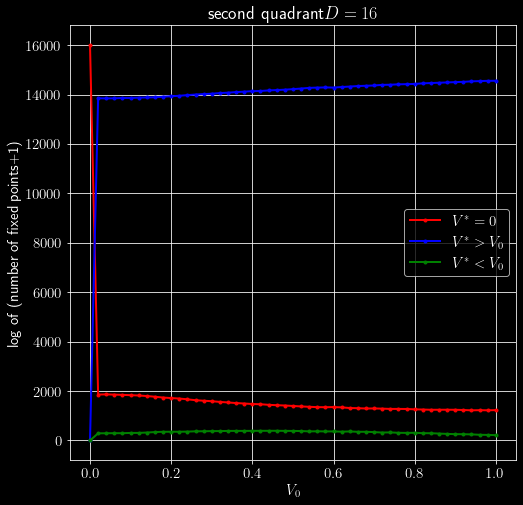

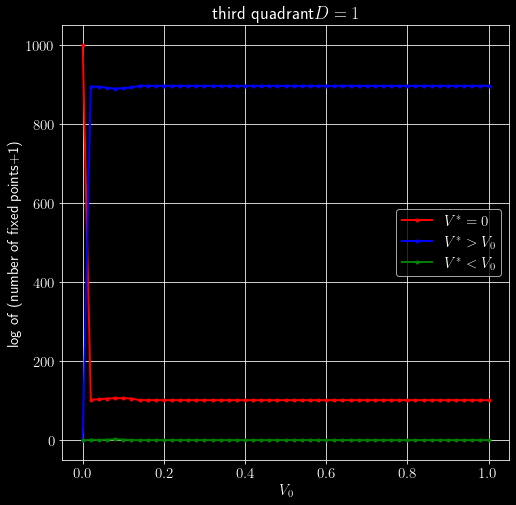

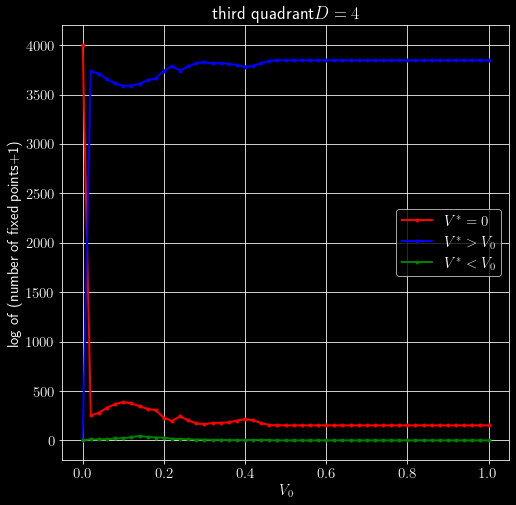

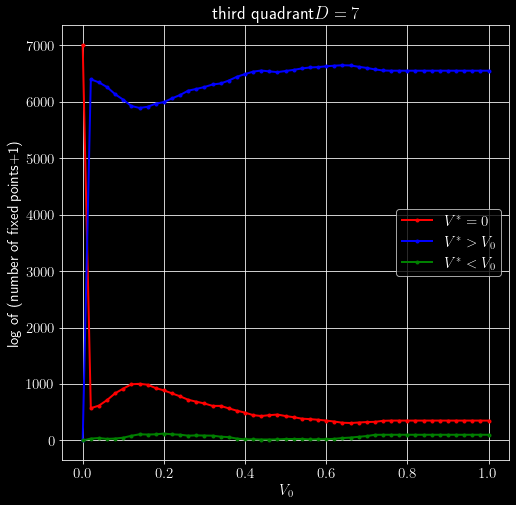

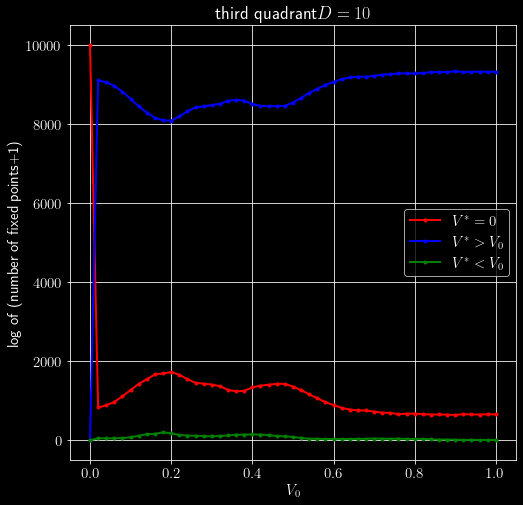

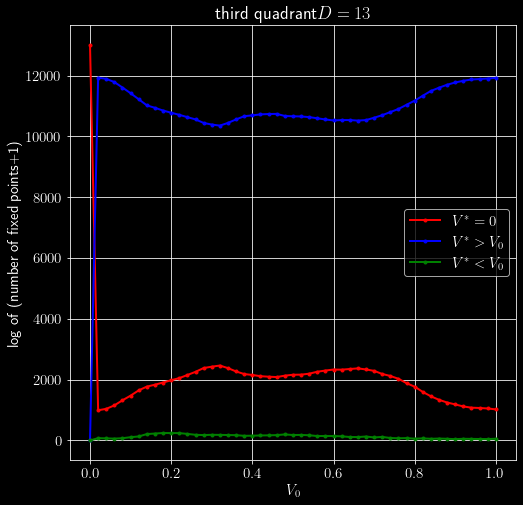

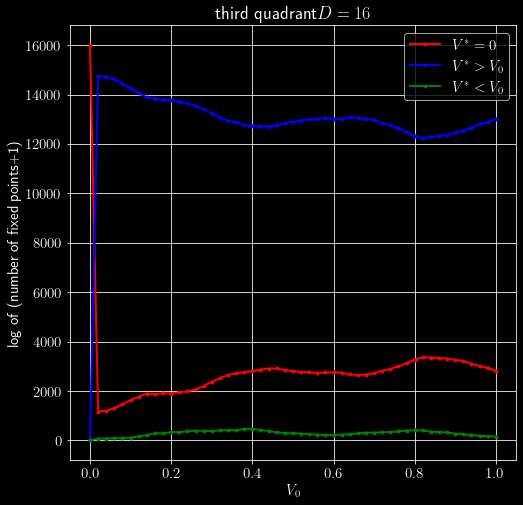

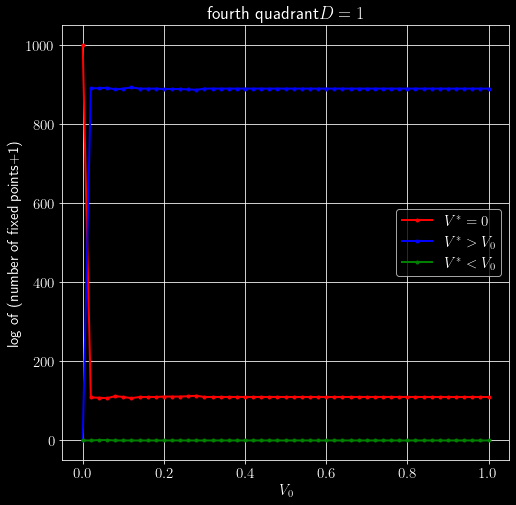

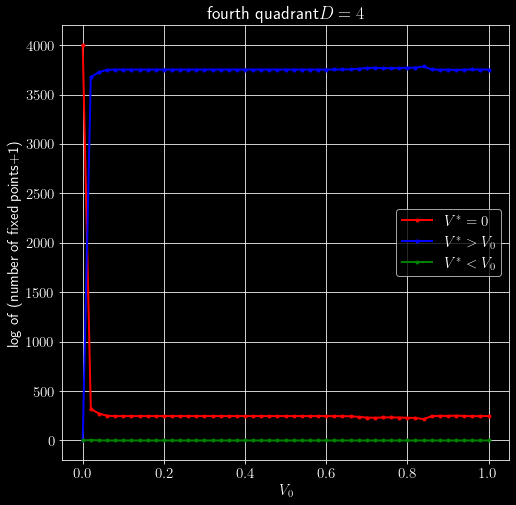

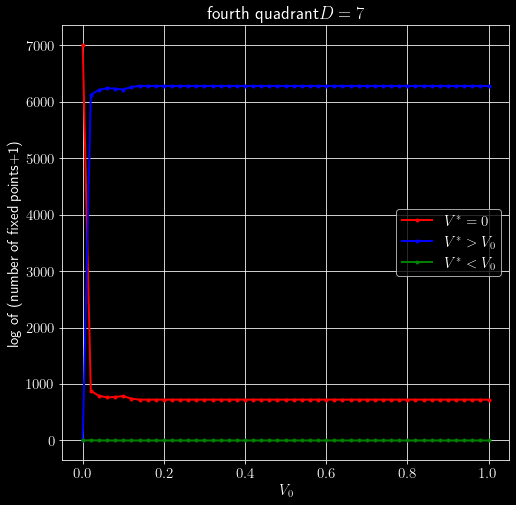

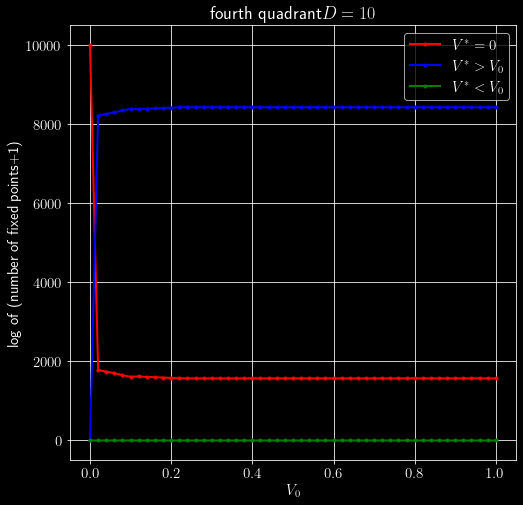

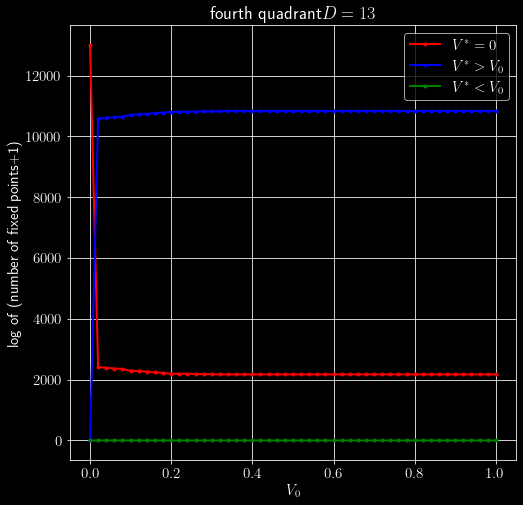

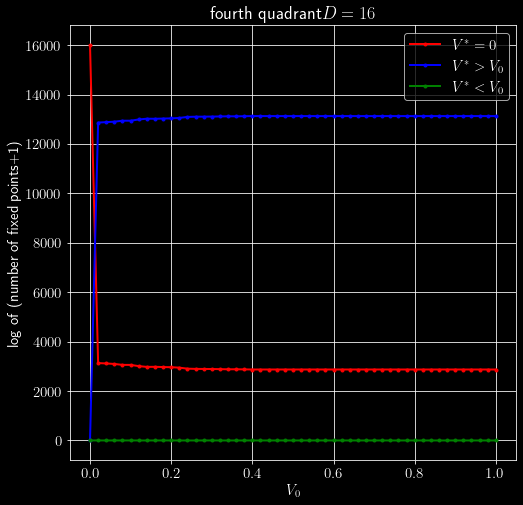

In [22]:
def count_Vfp(D0, V0, J0, K0, sign=1, delta=0.1):
    w_range = np.arange(-D0/2, D0/2, delta)
    U_range = np.arange(sign*delta, sign*(10 + delta), sign*delta)
    data = itertools.product(w_range, [D0], U_range, [V0], [J0], [K0])
    count = np.zeros(3)
    for outp in Pool(processes=10).starmap(complete_RG, data):
        V_fp = outp[4][-1]
        if V_fp ==0:
            count[0] += 1
        elif V_fp > V0:
            count[1] += 1
        elif V_fp < V0:
            count[2] += 1
    return count

def plot_Vcount(V0_range, count, title):
    plt.plot(V0_range, count[0], marker=".", color='r', label=r"$V^*=0$" )
    plt.plot(V0_range, count[1], marker=".", color='b', label=r"$V^* > V_0$")
    plt.plot(V0_range, count[2], marker=".", color='g', label=r"$V^* < V_0$")
    plt.legend()
    plt.title(title)
    plt.xlabel(r"$V_0$")
    plt.ylabel(r"log of (number of fixed points+1)")
    plt.show()

def plot_all(J0, K0, sign, title):
    D0_range = range(1, 17, 3)
    V0_range = np.arange(0,1.01,0.02)
    for D0 in D0_range:
        c0, c1, c2 = [], [], []
        for V0 in V0_range:
            count = count_Vfp(D0, V0, J0, K0, sign, delta=0.1)
            c0.append(count[0])
            c1.append(count[1])
            c2.append(count[2])
        plot_Vcount(V0_range, [c0, c1, c2], title+r"$D={}$".format(D0))

plot_all(0.4, 0.3, 1, r"first quadrant")
plot_all(0.3, 0.4, 1, r"second quadrant")
plot_all(0.3, 0.4, -1, r"third quadrant")
plot_all(0.4, 0.3, -1, r"fourth quadrant")

## b. Change in the fraction of irrelevant fixed points under increase in $D$

Next we will see how the ratio of number of fixed points in each class varies as we increase the bandwidth, for a particular $V \sim 10$ in the stable region.

In [12]:
def plot_frac(J0, K0, sign, title):
    D0_range = np.arange(10,91,20)
    frac = [].05
    for D0 in D0_range:
        print (D0)
        V0 = 10
        count = (count_fp(D0, V0, J0, K0, sign))
        frac.append(count[0]/sum(count))
    plt.plot(D0_range, frac, marker=".")
    plt.title(title)
    plt.xlabel(r"$D_0$")
    plt.ylabel(r"log of ratio of irr. to rel.")
    plt.show()


#plot_frac(0.04, 0.03, 1, r"first quadrant")
#plot_frac(0.03, 0.04, 1, r"second quadrant")
#plot_frac(0.03, 0.04, -1, r"third quadrant")
#plot_frac(0.04, 0.03, -1, r"fourth quadrant")

10
30
50
Process ForkPoolWorker-27:
Process ForkPoolWorker-30:
Process ForkPoolWorker-25:
Process ForkPoolWorker-29:
Process ForkPoolWorker-36:
Process ForkPoolWorker-35:
Process ForkPoolWorker-34:
Traceback (most recent call last):
Traceback (most recent call last):


## c. Change in the critical $V$ under increase in $D$

For the first and third quadrants, there is a critical value of $V$ at which the number of relevant and irrelevant fixed points become equal. We will now see how this value depends on the bandwidth $D$.

In [ ]:

def Vc_vs_D(J0, K0, sign, title):
    D0_range = range(10,91,20)
    Vc = [get_Vc(D0, J0, K0, sign, title) for D0 in D0_range]
    plt.plot(D0_range, Vc, marker=".")
    plt.title(title)
    plt.xlabel(r"$D_0$")
    plt.ylabel(r"$V_c$")
    plt.show()


#Vc_vs_D(0.4, 0.3, 1, r"first quadrant")
#Vc_vs_D(0.3, 0.4, -1, r"third quadrant")